# Introduction to Convolutional Neural Networks

This notebook contains code generating examples explaining the intuition of the convolutional filter and max pool step op a convolutional neural network as well as the intuition of the gradient descent algorithm.

## The intution of convolution and max pooling

We start by importing needed libraries.

In [1]:
%matplotlib inline

import math, sys, os
import numpy as np
import six.moves.cPickle as pickle

from numpy.linalg import norm
from PIL import Image
from matplotlib import pyplot as plt, rcParams, rc
from scipy.ndimage import imread
from scipy.ndimage.filters import correlate, convolve
from skimage.measure import block_reduce
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
from tensorflow.examples.tutorials.mnist import input_data
from __future__ import print_function

# Set up matplotlib to display animation in the notebook
rc('animation', html = 'html5')
rcParams['figure.figsize'] = 3, 6

# Set global precision for numpy
%precision 4
np.set_printoptions(precision = 4, linewidth = 100)

We then import the MNIST data set. MNIST is a large dataset of handwritten digits that is commonly used for training various image processing systems and machine learning models.

The MNIST dataset is one of the example dataset included with TensorFlow. It has 55,000 handwritten and labeled 28x28 pixel numbers.

In [2]:
# Read the MNIST dataset from the TensorFlow examples.
mnist = input_data.read_data_sets("MNIST_data/")

# The images and labels are stores as methods. Extract these into stand alone objects
images, labels = mnist.train.images, mnist.train.labels

# When importing the images, they are stored in a sing 55000 x 784 numpy array.
# That is each image is stored in a one dimensional array of 784 pixels. We reshape
# the array, such that each image is instead stored in a 28 x 28 arrauy. Reflecting the
# actual shape of the image.
images = images.reshape((55000, 28, 28))

# Save the array into a single file in compressed .npz format
np.savez_compressed("MNIST_data/train", images = images, labels = labels)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We then define some plot functions for later use.

In [3]:
def plots(ims, interp = False, titles = None):
    
    ims=np.array(ims)
    mn, mx = ims.min(), ims.max()
    
    f = plt.figure(figsize = (12, 24))
    
    for i in range(len(ims)):
        
        sp = f.add_subplot(1, len(ims), i + 1)
        
        if not titles is None: sp.set_title(titles[i], fontsize = 18)
            
        plt.imshow(ims[i], interpolation = None if interp else 'none', vmin = mn,vmax = mx)

def plot(im, interp = False):
    f = plt.figure(figsize=(3, 6), frameon = True)
    plt.imshow(im, interpolation = None if interp else 'none')
    
def plot_int(im):
    f = plt.figure(figsize=(3, 6), frameon = True)
    plt.show(im)

plt.gray()
plt.close()

We load the data from the files stored. (We have stored the file earlier, such that we do not have to rely on having TensorFlow available).

In [4]:
# Load data
data = np.load("MNIST_data/train.npz")

# Separate into images and label arrays
images = data['images']
labels = data['labels']

# Define length of array (55,000) and print the shape (dimensions of the array)
n = len(images)
images.shape

(55000, 28, 28)

We can then plot a sample image and the label.

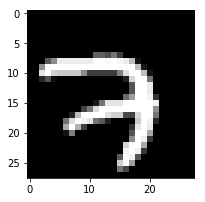

In [5]:
plot(images[0])

In [6]:
labels[0]

7

We can also plot the first 5 numbers and associated labels.

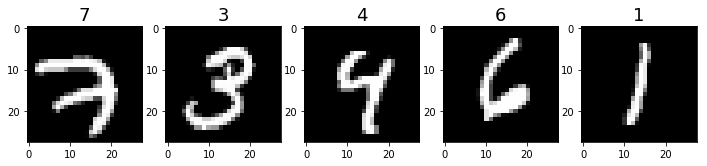

In [7]:
plots(images[:5], titles = labels[:5])

Now lets define a simple 3 x 3 matrix of pixels. This is our first filter. Now, what will have happen when we shift the filter accross the number matrixes. At each point we multiply the matrices element wise and take the sum.

For a cool visualisation of how the multiplication works see [this link](http://setosa.io/ev/image-kernels/)

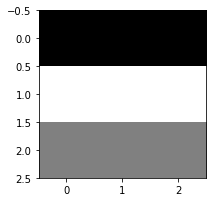

In [8]:
top = [[-1,-1,-1],
       [ 1, 1, 1],
       [ 0, 0, 0]]

plot(top)

Lets zoom in on the top part to see how the filter works on our numbers

In [9]:
r = (0, 28)
def zoomim(x1 = 0, x2 = 28, y1 = 0, y2 = 28):
    plot(images[0, y1:y2, x1:x2])
    plt.show()
    
w = interactive(zoomim, x1 = r, x2 = r, y1 = r, y2 = r)
w

Now lets study what actually happens with the pixels. First we print the actual pixel values of the zoomed image.

In [10]:
k = w.kwargs
dims = np.index_exp[k['y1']:k['y2']:1, k['x1']:k['x2']]
images[0][dims]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , 

Now we perform the actual calculation. It is called correlating - in that we correlate the image and the filter. We correlate the image and the filter and print the result as pixel and as image.

In [11]:
corrtop = correlate(images[0], top)
corrtop[dims]

array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    , 

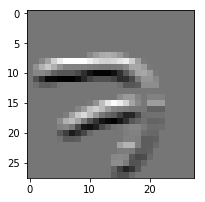

In [12]:
plot(corrtop[dims])

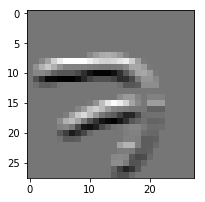

In [13]:
plot(corrtop)

We see that in correlating image and the filter, we get a new image where lines/edges on top a shape is highlighted. Before deep learning this is what people would do by hand in crafting features for their image recognition models - i.e. feature engineering.

We can then rotate our filter 90 degrees.

In [14]:
np.rot90(top, 1)

array([[-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0]])

When we keep rotating we get filters in which we can detect edges on all sides of shapes in our image.

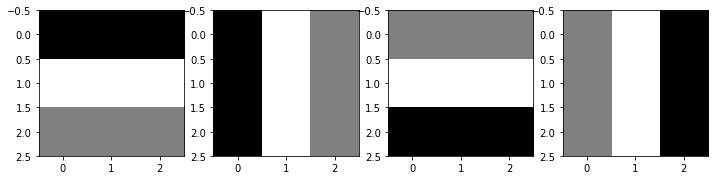

In [15]:
straights = [np.rot90(top, i) for i in range(4)]
plots(straights)

All imagerecognition today basically utalises convolutional neural networks. How did they get that name?

What does convolution mean? Well basically it's the same mathematical opperation as when correlating. The only difference is that in convolution you take the original filter and rotate it 180 degrees before performing the mathematical opperations.

We can easily proove that.

True

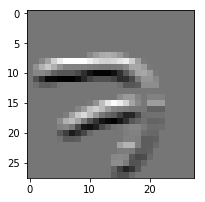

In [16]:
# Perform the convolution on the original filter rotated 180 degrees perfore. When
# we convolve it will be rotated 180 degrees again and we get the original shape again.
convtop = convolve(images[0], np.rot90(top, 2))

# We then plot the output of the convolution and see that it is exactly the same output
# as our correlation above.
plot(convtop)
np.allclose(convtop, corrtop)

We can also make filters that detect diagonal edges.

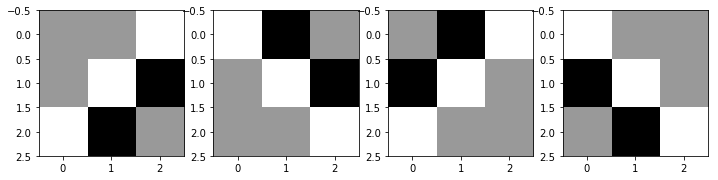

In [17]:
br = [[ 0, 0, 1],
      [ 0, 1,-1.5],
      [ 1,-1.5, 0]]

diags = [np.rot90(br, i) for i in range(4)]
plots(diags)

We can then correlate all the filters across our image and see that we can detect all the edges of the image. Thus we have some engineered features.

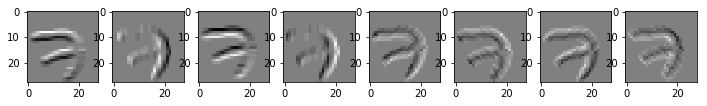

In [18]:
rots = straights + diags
corrs = [correlate(images[0], rot) for rot in rots]
plots(corrs)

In deep learning we basically wants to extract the fingerprint of each image. That is, how does a certain object look on average across all images of the object in the trianing data set.

A way to do this is to use max pooling. We shift across the image again, this time in a 7 x 7 grid and return the max pixel. I.e. the brightest pixel. Thus for each filter we get a 4 x 4 representation of the image. Essentially our "finger print."

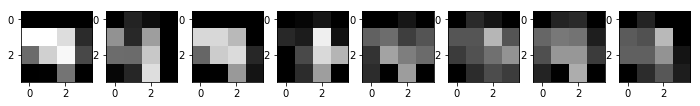

In [19]:
def pool(im): return block_reduce(im, (7, 7), np.max)

plots([pool(im) for im in corrs])

We can then utalise this on our data set in order to classify ones and eights (chosen as they are subjectively the most different types of numbers). We start by grapping the ones and eights and plotting some examples.

In [20]:
eights = [images[i] for i in range(n) if labels[i] == 8]
ones = [images[i] for i in range(n) if labels[i] == 1]

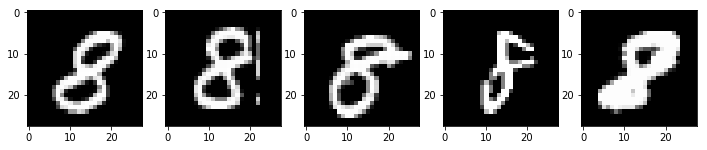

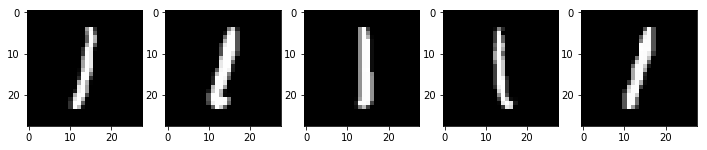

In [21]:
plots(eights[:5])
plots(ones[:5])

We then run the correlation with all the filters and do max pooling on top for the eights.

In [22]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights]) for rot in rots]

We see that out dataset has 5389 images containing eights. For each image we now have eight 4 x 4 representations of the image. One for each filter.

In [23]:
len(pool8), pool8[0].shape

(8, (5389, 4, 4))

And we can plot the first filter of the first 5 images.

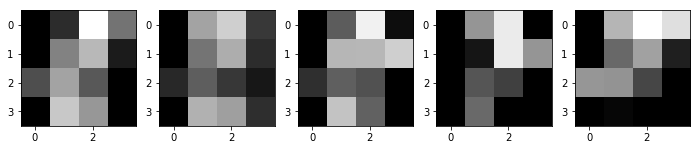

In [24]:
plots(pool8[0][0:5])

We can then take the mean accross each filter such that we get a filter the average filter representation of all the eights. Having taken the mean, we can also normalise across the filters. We can see this as an ideal representation of an eight.

In [25]:
def normalize(arr): return (arr - arr.mean()) / arr.std()

In [26]:
filts8 = np.array([ims.mean(axis = 0) for ims in pool8])
filts8 = normalize(filts8)

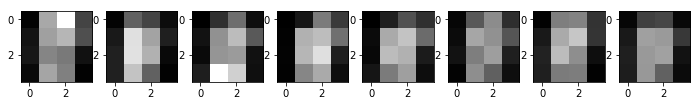

In [27]:
plots(filts8)

So we have 8 4x4 representations, being the average filter of an eight.

In [28]:
filts8.shape

(8, 4, 4)

We then do the same for the ones. Immediately wee see a difference in the representation. Eg. ones have strong vetical edges and almost none diagonal edges when compared to the eights.

In [29]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones]) for rot in rots]

print(len(pool1), pool1[0].shape)

filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

8 (6179, 4, 4)


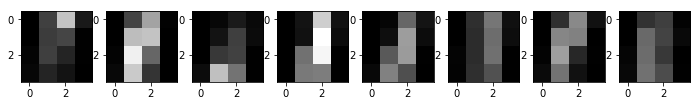

In [30]:
plots(filts1)

We can then utalise this to make a simple digit recognition algorithm. We do this by correlating every image and filter in our dataset and compare it to the "ideal" representations of our ones and eights above.

We start we writing a function that performs both the correlation and the max pooling. (Remember `rot` is the 8 filters (4 vertical/horisontal and 4 diagonal).

In [31]:
def pool_corr(im): return np.array([pool(correlate(im, rot)) for rot in rots])

Below we see the calculated correlation for our first eight.

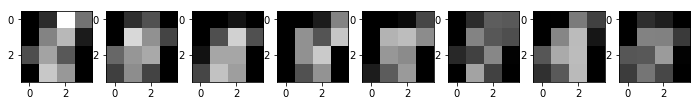

In [32]:
plots(pool_corr(eights[0]))

We can now define a function to determine wether or not a number is an eight or not.

In [33]:
# Function calculating the sum of squared errors
def sse(a, b): return ((a - b) ** 2).sum()

# Function returning a 1 if the sum of squared errors between the max pooled image and filter 
# correlation and the average one filters (the ideal representation) is greater then the sum
# of squared errors of the max pooled image and filter correlation and the average eight 
# filters.
def is8_n2(im): return 1 if sse(pool_corr(im), filts1) > sse(pool_corr(im), filts8) else 0

We can test this on the first eight image, where we see that we do indeed obtain a lower sum of squared error for the eight filters than for the one filters.

In [34]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(126.77776, 181.26105)

We can then run the function across the entire dataset of eights and ones. In the output below we see, that we majorily identify the eights. 5223 out the 5389 eights in the dataset. However, we do also misclassify some of the ones, 287 out of 6179.

In [35]:
[np.array([is8_n2(im) for im in ims]).sum() for ims in [eights, ones]]

[5223, 287]

We can also do the same for `1 - is8_n2(im)`, that is determine if its not an eight. Here we hit 5892 out of 6179 and mis 166 out of 5389.

In [36]:
[np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights,ones]]

[166, 5892]

We can check the same result when using a different loss function. For instance the sum of absolute errors.

In [37]:
# Function calculating the sum of absolute errors
def n1(a, b): return (np.fabs(a - b)).sum()

# Function returning a 1 if the sum of absolute errors between the max pooled image and filter 
# correlation and the average one filters (the ideal representation) is greater then the sum
# of absolute errors of the max pooled image and filter correlation and the average eight 
# filters.
def is8_n1(im): return 1 if n1(pool_corr(im),filts1) > n1(pool_corr(im),filts8) else 0

For detecting eights we get slightly lower misclassfication (false positives) but also lower true positives.

In [38]:
[np.array([is8_n1(im) for im in ims]).sum() for ims in [eights,ones]]

[5129, 254]

For detecting "not eights" (ones) we get more false positives but also more true positives.

In [39]:
[np.array([(1-is8_n1(im)) for im in ims]).sum() for ims in [eights,ones]]

[260, 5925]

## Making the algorithm better

So how do we make this algorithm better?

1. Instead of using the 8 simple features (filters) that we created, there are much better alternatives. Specifically there are a lot of better 3 x 3 filters, that we could be using.

2. We also treat all the filters as equally important. Some filters might be more important than others.

3. More complex filters. Not just lines and diagonals, but eg. corners.

Deep learning does all of this for us. Deep learning is simply an optimisation problem across the points specified above (could be more steps, eg. non-linearity). In the optimisation problem we simply start with random values for each filter (we specify the number 8, 100, etc.) The optimisation algorithm then attempts to make the filters better and better for each iteration.

The process is that of backpropagation through the neural network. Essentially it is a stochastic gradient descent algorithm, the intuition of which is presented below.

## Stochastic Gradient Descent

We here present the intuition of stochastic gradient descent, exemplified by linear regression - the deep learning way. We start by importing the libraries adn functions we will use.

In [40]:
%matplotlib inline

import math, sys, os
import numpy as np

from numpy.random import random
from matplotlib import pyplot as plt, rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
from IPython.display import FileLink

# Set up matplotlib to display animation in the notebook
rc('animation', html = 'html5')
rcParams['figure.figsize'] = 3, 3

# Set global precision for numpy
%precision 4
np.set_printoptions(precision = 4, linewidth = 100)

Define the function for a line

In [41]:
def lin(a, b, x): return a * x + b

We can then set up some data - i.e. actual values of `a` and `b`.

In [42]:
a = 3.
b = 8.

Next we generate some random data.

In [43]:
n = 30
x = random(n)
y = lin(a, b, x)

So `x` and `y` here is out data based on which we would like to find the values of `a` and `b`, which would be onknown in a real seeting. This is equivalent to finding the values of the optimal filters in the convolution example above. We can consider out data.

In [44]:
x

array([ 0.4041,  0.6579,  0.0904,  0.5703,  0.7956,  0.0259,  0.0037,  0.6457,  0.125 ,  0.6817,
        0.7392,  0.296 ,  0.2347,  0.5008,  0.3126,  0.0321,  0.5661,  0.7986,  0.0209,  0.6541,
        0.5651,  0.0891,  0.1011,  0.8209,  0.6943,  0.8771,  0.0105,  0.7529,  0.5557,  0.2635])

In [45]:
y

array([  9.2123,   9.9736,   8.2712,   9.711 ,  10.3868,   8.0777,   8.011 ,   9.9372,   8.375 ,
        10.0452,  10.2175,   8.8879,   8.7042,   9.5024,   8.9377,   8.0962,   9.6984,  10.3959,
         8.0628,   9.9623,   9.6952,   8.2673,   8.3032,  10.4628,  10.0829,  10.6314,   8.0314,
        10.2587,   9.6672,   8.7905])

We can also plot the data.

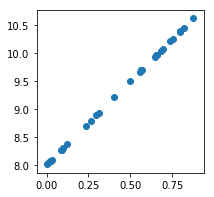

In [46]:
plt.scatter(x, y)

We can then evaluate out prediction as before utilising the sum of squared errors, which will be out loss function.

In [47]:
# Function computing the sum of squared error between a vector of predictions and true values.
def sse(y, y_pred): return ((y-y_pred)**2).sum()

# Function computing the loss function for our liniear regression. 
def loss(y,a,b,x): return sse(y, lin(a, b, x))

# Function computing the "average" loss, i,e, taking the root of sum of squared errors and
# deviding by the number of observations.
def avg_loss(y, a, b, x): return np.sqrt(loss(y, a, b, x) / n)

We then initialise the algorithm by chosing some random values of a and b and compute our loss.

In [48]:
a_guess = -1.
b_guess = 1.
avg_loss(y, a_guess, b_guess, x)

8.7960

So on average we miss the true values for each x_i with this values. So how do we improve this? Can we improve the result by changing `a` and `b` by a small amount? Yes we can. See the intution in this spreadsheet:

In [49]:
FileLink('graddesc.xlsm')

C:\Users\anlaursen\local-libraries\deep-learning-intro\cnn-introduction\graddesc.xlsm

How do we define what a and b should change by? It is up for grabs. It's called the learning rate and here we set it as 0.01.

In [50]:
lr = 0.01

# d[(y - (a * x + b)) ** 2, a] = 2 x (b + a x - y)    = x * dy/db

We can then specify our optimisation algorithm. This is the gradient descent algorithm.

In [51]:
def upd():
    
    # Specify the a and b guess as global values.
    global a_guess, b_guess
    
    # Calculate our prediction
    y_pred = lin(a_guess, b_guess, x)
    
    # Calculate the partial derivative (gradient) of the loss function in regards to b
    # d[(y - (a * x + b)) ** 2, b] = 2 (b + a x - y) = 2 (y_pred - y)
    dydb = 2 * (y_pred - y)
    
    # Calculate the partial derivative (gradient) of the loss function in regards to a
    # d[(y - (a * x + b)) ** 2, a] = 2 x (b + a x - y) = x * dy/db
    dyda = x * dydb
    
    # We then update our guesses by this change multiplied by our learning rate.
    a_guess -= lr * dyda.mean()
    b_guess -= lr * dydb.mean()

We can then animate what happens as we run our stochastic gradient descent algorithm. Note, running the code requires the yasm and ffmpeg library).

In [52]:
# Run the animation
fig = plt.figure(dpi = 100, figsize = (5, 4))
plt.scatter(x, y)
line, = plt.plot(x, lin(a_guess, b_guess, x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess, b_guess, x))
    for i in range(10): upd()
    return line,

# Run the update 40 times
ani = animation.FuncAnimation(fig, animate, np.arange(0, 40), interval = 100)
ani

In convolutional neural networks we take this approach and apply it on each of our filters. Typically our filters will themselves be input to other filters which will be optimised. This approach can lead to eg. cornor detection by taking som from the horisontal and vertical base filter.

On page 824 in [this](https://www.cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf) paper by [Matthew D. Zeiler](http://www.matthewzeiler.com) and [Rob Fergus](http://cs.nyu.edu/~fergus/pmwiki/pmwiki.php), examples from a five layer CNN is showed, where the filter and activation for the first filter is shown and the activation of the five last filters is shown as well. (Matthew D. Zeiler went on to win ImageNet the year after writing the paper).

Deep learning models today typically utilises more than 1000 filters. Imagine the exponential improving levels of semantic richness and the consequences for machine learning models.